# Food Vision using all the data from Food101

Aim:
>* Will incorporate Mixed Precision
>>* Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).
>* Dataset from Tensorflow Dataset
>* Train data	75,750 images	
>* Test data	25,250 images
>* Beat Original DeepFood paper, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Getting the Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/Krishnak561/tensorflow-deep-learning/main/extras/helper_functions.py

# Importing helper functions that will be used in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-06-22 17:44:33--  https://raw.githubusercontent.com/Krishnak561/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-22 17:44:33 (83.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Downloading the Dataset

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In [ ]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteS0MFGO/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteS0MFGO/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
ds_info.features["image"].shape

(None, None, 3)

In [ ]:
training_data_sample = train_data.take(1)

for image, label in training_data_sample:
  print(f"""
  Image Shape: {image.shape}
  Image dtype: {image.dtype}
  Label: {label}
  Class Name: {class_names[label]}
        """)



  Image Shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Label: 23
  Class Name: churros
        


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot the Image

Text(0.5, 1.0, 'churros')

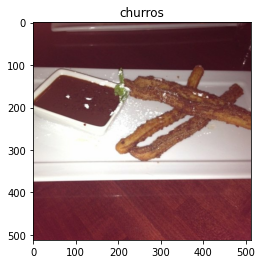

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label])

## Preprocessing Data

More specifically, our data is currently:

>* In uint8 data type
>* Comprised of all differnet sized tensors (different sized images)
>* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

>* In float32 data type
>* Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
>* Scaled (values between 0 & 1), also called normalized

In [ ]:
def preprocess(image, label, img_size = 224):
  image = tf.cast(image, dtype = tf.float32)
  image = tf.image.resize(image, [img_size, img_size])

  return image, label


In [ ]:
print(preprocess(image, label))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 93.      ,  34.      ,  40.      ],
        [ 94.      ,  35.      ,  41.      ],
        [ 95.      ,  36.      ,  42.      ],
        ...,
        [ 55.      ,  15.      ,  24.      ],
        [ 52.      ,  15.      ,  23.      ],
        [ 52.      ,  15.      ,  23.      ]],

       [[ 93.92857 ,  34.928574,  40.928574],
        [ 93.07143 ,  34.071426,  40.071426],
        [ 94.      ,  35.      ,  41.      ],
        ...,
        [ 55.      ,  15.      ,  24.      ],
        [ 54.      ,  14.      ,  23.      ],
        [ 52.      ,  15.      ,  23.      ]],

       [[ 93.928566,  35.357143,  41.57143 ],
        [ 91.64285 ,  33.071426,  39.285713],
        [ 91.78571 ,  33.214287,  39.428574],
        ...,
        [ 54.      ,  14.      ,  23.      ],
        [ 55.      ,  15.      ,  24.      ],
        [ 55.      ,  15.      ,  24.      ]],

       ...,

       [[108.01023 ,  31.010233,  49.01023 ],
        [108

## Batching and Preparing Dataset

Specifically, we're going to be using:

>* **map()** - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
>* **shuffle()** - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
>* **batch()** - turns elements of a target dataset into batches (size defined by parameter batch_size)
>* **prefetch()** - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
>* **Extra: cache()** - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating CallBacks

In [ ]:
modelCheckPointPath = "foodVision/checkpoint.ckpt"

modelCheckPoint = tf.keras.callbacks.ModelCheckpoint(filepath=modelCheckPointPath, 
                                                     verbose = 1,
                                                     save_best_only = False,
                                                     save_weights_only = True,
                                                     save_freq = 'epoch')

## Setting Mixed Precision 

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


## Feature Extraction - Building the Model

In [ ]:
len(class_names)

101

In [ ]:
initial_epochs = 3

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False;

inputs = tf.keras.Input(shape = (224, 224, 3))

x = base_model(inputs, training = False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(len(class_names), activation= "softmax", dtype = tf.float32)(x)

model = tf.keras.Model(inputs, outputs)


model.compile(loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"],
              optimizer = "Adam")

history_before = model.fit(train_data, epochs = 3, steps_per_epoch = len(train_data),
                           validation_data = test_data, validation_steps = int(.15 * len(test_data)),
                           callbacks = [create_tensorboard_callback("tensorflow", "FoodVision101"), modelCheckPoint])

In [ ]:
results_1 = model.evaluate(test_data)
results_1